<a href="https://colab.research.google.com/gist/snsamarasekara/aa5f977bfa394f9e2f101c4b0e99f190/copy-of-resnet50-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Flatten, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical


In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:06<00:00, 151MB/s]
100% 1.14G/1.14G [00:06<00:00, 199MB/s]


In [ ]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.8 MB/s 
     |████████████████████████████████| 1.2 MB 60.1 MB/s 
     |████████████████████████████████| 197 kB 73.8 MB/s 
     |████████████████████████████████| 60 kB 8.8 MB/s 
Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd 
import random

import matplotlib.pyplot as plt

In [ ]:
pip install opencv-python

In [ ]:
import cv2

In [ ]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
#from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

In [ ]:
seed = 232
np.random.seed(seed)


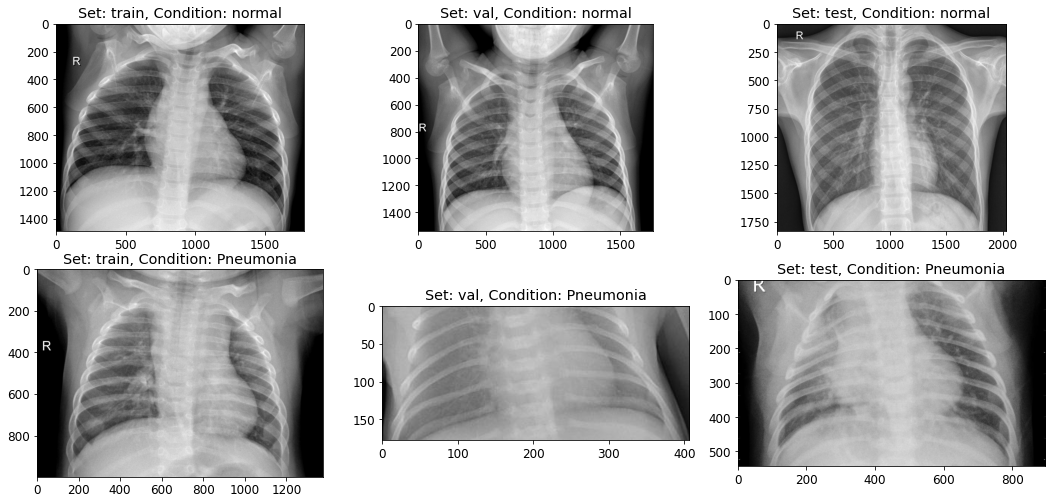

In [ ]:
input_path = r"/content/dataset/cnn/pneumonia_revamped"

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+'/'+_set
    ax[i].imshow(plt.imread(set_path+'/normal/'+os.listdir(set_path+'/normal')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/opacity/'+os.listdir(set_path+'/opacity')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + '/'+_set + '/normal'))
    n_infect = len(os.listdir(input_path + '/'+_set + '/opacity'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1082, pneumonia images: 3110
Set: val, normal images: 267, pneumonia images: 773
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
input_path = r"/content/dataset/cnn/pneumonia_revamped"

def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'/'+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'/'+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    
    test_data = []
    test_labels = []

    for cond in ['/normal/', '/opacity/']:
        for img in (os.listdir(input_path + '/'+ 'test' + cond)):
            img = plt.imread(input_path+'/'+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/opacity/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model architecture

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
131/131 [==============================] - 78s 497ms/step - loss: 0.3841 - accuracy: 0.8156 - val_loss: 0.7726 - val_accuracy: 0.6217 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 63s 483ms/step - loss: 0.2753 - accuracy: 0.8853 - val_loss: 0.8539 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 63s 482ms/step - loss: 0.2449 - accuracy: 0.8946 - val_loss: 1.3097 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 63s 483ms/step - loss: 0.2380 - accuracy: 0.9096 - val_loss: 1.1404 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 63s 484ms/step - loss: 0.2240 - accuracy: 0.9077 - val_loss: 1.5110 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - 64s 485ms/step - loss: 0.2143 - accuracy: 0.9172 - val_loss: 0.5049 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 7/10
131/131 [==============================] 

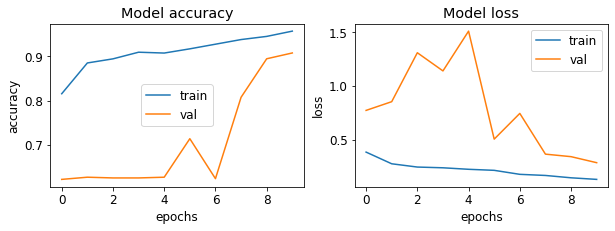

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[188  46]
 [ 10 380]]

TEST METRICS ----------------------
Accuracy: 91.02564102564102%
Precision: 89.2018779342723%
Recall: 97.43589743589743%
F1-score: 93.13725490196079

TRAIN METRIC ----------------------
Train acc: 95.73
